In [1]:
from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output


from __future__ import print_function

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
import pyspark

In [113]:
conn = MongoClient()
db = conn.Tracker
collection = [db.leo]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))

In [114]:
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.isnull().sum().sum()

367

In [115]:
df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

In [116]:
df = df[(df['hr_value'] != 0)]

In [117]:
df.head()

,_id,day,hour,hr_value,latitude,longitude,minute,month,o2_value,second,step_value,timestamp,year
0,5c9b3bccc4e5a668b7e9beb2,27,17,NaN,NaN,NaN,0,3,NaN,51,NaN,1.553677e+09,2019
1,5c9b3bd6c4e5a668b7e9beb6,27,17,NaN,NaN,NaN,1,3,NaN,1,0.0,1.553677e+09,2019
2,5c9b3be0c4e5a668b7e9beba,27,17,NaN,NaN,NaN,1,3,NaN,11,0.0,1.553677e+09,2019
3,5c9b3beac4e5a668b7e9bebe,27,17,NaN,NaN,NaN,1,3,NaN,21,0.0,1.553677e+09,2019
4,5c9b3bf4c4e5a668b7e9bec2,27,17,NaN,NaN,NaN,1,3,NaN,31,0.0,1.553677e+09,2019


In [118]:
dfspark = df.loc[:,['hr_value', 'step_value']] #  'o2_value'
dfspark.to_csv('input.csv', index=True)
dfspark.head()

,hr_value,step_value
0,NaN,NaN
1,NaN,0.0
2,NaN,0.0
3,NaN,0.0
4,NaN,0.0


In [119]:
# %matplotlib notebook
# threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
# threedee.scatter(dfspark[:,0], dfspark[:,1], dfspark[:,2], c=y)
# threedee.set_xlabel('hr_value')
# threedee.set_ylabel('o2_value')
# threedee.set_zlabel('step_value')
# plt.show()


# threedee = plt.figure().gca(projection='3d')
# threedee.scatter(dfspark.index,dfspark['hr_value'],dfspark['step_value'])
# threedee.set_xlabel('index')
# threedee.set_ylabel('hr_value')
# threedee.set_zlabel('step_value')
# plt.show()

In [120]:
sc = SparkContext(appName="pysparkKmeas") # exist by default
sqlContext = SQLContext(sc)

In [121]:
FEATURES_COL = ['hr_value', 'step_value']
path = 'input.csv'

In [122]:
dfspark = sqlContext.read.csv(path, header=True) # requires spark 2.0
dfspark.show()

+---+--------+----------+
|_c0|hr_value|step_value|
+---+--------+----------+
|  0|    null|      null|
|  1|    null|       0.0|
|  2|    null|       0.0|
|  3|    null|       0.0|
|  4|    null|       0.0|
|  5|    74.0|       0.0|
|  6|    74.0|       0.0|
|  7|    74.0|       0.0|
|  8|    74.0|      27.0|
|  9|    74.0|       0.0|
| 10|    74.0|      21.0|
| 11|    74.0|       0.0|
| 12|    74.0|       0.0|
| 13|    74.0|       0.0|
| 14|    74.0|       0.0|
| 15|    74.0|       0.0|
| 16|    74.0|      22.0|
| 17|    74.0|       0.0|
| 18|    74.0|      36.0|
| 19|    74.0|      12.0|
+---+--------+----------+
only showing top 20 rows



In [123]:
lines = sc.textFile(path)
data = lines.map(lambda line: line.split(","))
data.take(2)

[[u'', u'hr_value', u'step_value'], [u'0', u'', u'']]

In [124]:
dfspark = data.toDF(['id','hr_value', 'step_value'])
print (dfspark)
dfspark.show()

DataFrame[id: string, hr_value: string, step_value: string]
+---+--------+----------+
| id|hr_value|step_value|
+---+--------+----------+
|   |hr_value|step_value|
|  0|        |          |
|  1|        |       0.0|
|  2|        |       0.0|
|  3|        |       0.0|
|  4|        |       0.0|
|  5|    74.0|       0.0|
|  6|    74.0|       0.0|
|  7|    74.0|       0.0|
|  8|    74.0|      27.0|
|  9|    74.0|       0.0|
| 10|    74.0|      21.0|
| 11|    74.0|       0.0|
| 12|    74.0|       0.0|
| 13|    74.0|       0.0|
| 14|    74.0|       0.0|
| 15|    74.0|       0.0|
| 16|    74.0|      22.0|
| 17|    74.0|       0.0|
| 18|    74.0|      36.0|
+---+--------+----------+
only showing top 20 rows



In [125]:
df_feat = dfspark.select(*(dfspark[c].cast("float").alias(c) for c in dfspark.columns[1:]))
df_feat.show()

+--------+----------+
|hr_value|step_value|
+--------+----------+
|    null|      null|
|    null|      null|
|    null|       0.0|
|    null|       0.0|
|    null|       0.0|
|    null|       0.0|
|    74.0|       0.0|
|    74.0|       0.0|
|    74.0|       0.0|
|    74.0|      27.0|
|    74.0|       0.0|
|    74.0|      21.0|
|    74.0|       0.0|
|    74.0|       0.0|
|    74.0|       0.0|
|    74.0|       0.0|
|    74.0|       0.0|
|    74.0|      22.0|
|    74.0|       0.0|
|    74.0|      36.0|
+--------+----------+
only showing top 20 rows



In [126]:
for col in dfspark.columns:
    if col in FEATURES_COL:
        dfspark = dfspark.withColumn(col,dfspark[col].cast('float'))
dfspark.show()

+---+--------+----------+
| id|hr_value|step_value|
+---+--------+----------+
|   |    null|      null|
|  0|    null|      null|
|  1|    null|       0.0|
|  2|    null|       0.0|
|  3|    null|       0.0|
|  4|    null|       0.0|
|  5|    74.0|       0.0|
|  6|    74.0|       0.0|
|  7|    74.0|       0.0|
|  8|    74.0|      27.0|
|  9|    74.0|       0.0|
| 10|    74.0|      21.0|
| 11|    74.0|       0.0|
| 12|    74.0|       0.0|
| 13|    74.0|       0.0|
| 14|    74.0|       0.0|
| 15|    74.0|       0.0|
| 16|    74.0|      22.0|
| 17|    74.0|       0.0|
| 18|    74.0|      36.0|
+---+--------+----------+
only showing top 20 rows



In [127]:
dfspark = dfspark.na.drop()
dfspark.show()

+---+--------+----------+
| id|hr_value|step_value|
+---+--------+----------+
|  5|    74.0|       0.0|
|  6|    74.0|       0.0|
|  7|    74.0|       0.0|
|  8|    74.0|      27.0|
|  9|    74.0|       0.0|
| 10|    74.0|      21.0|
| 11|    74.0|       0.0|
| 12|    74.0|       0.0|
| 13|    74.0|       0.0|
| 14|    74.0|       0.0|
| 15|    74.0|       0.0|
| 16|    74.0|      22.0|
| 17|    74.0|       0.0|
| 18|    74.0|      36.0|
| 19|    74.0|      12.0|
| 20|    74.0|       4.0|
| 21|    74.0|       0.0|
| 22|    74.0|       0.0|
| 23|    82.0|       0.0|
| 24|    82.0|       0.0|
+---+--------+----------+
only showing top 20 rows



In [128]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(dfspark).select('id', 'features')
df_kmeans.show()

+---+-----------+
| id|   features|
+---+-----------+
|  5| [74.0,0.0]|
|  6| [74.0,0.0]|
|  7| [74.0,0.0]|
|  8|[74.0,27.0]|
|  9| [74.0,0.0]|
| 10|[74.0,21.0]|
| 11| [74.0,0.0]|
| 12| [74.0,0.0]|
| 13| [74.0,0.0]|
| 14| [74.0,0.0]|
| 15| [74.0,0.0]|
| 16|[74.0,22.0]|
| 17| [74.0,0.0]|
| 18|[74.0,36.0]|
| 19|[74.0,12.0]|
| 20| [74.0,4.0]|
| 21| [74.0,0.0]|
| 22| [74.0,0.0]|
| 23| [82.0,0.0]|
| 24| [82.0,0.0]|
+---+-----------+
only showing top 20 rows



In [129]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

In [130]:
# fig, ax = plt.subplots(1,1, figsize =(8,6))
# ax.plot(range(2,20),cost[2:20])
# ax.set_xlabel('k')
# ax.set_ylabel('cost')

In [131]:
k = 2
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[99.66401195  1.91662519]
[67.82892701  0.58089472]


In [132]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id=u'5', prediction=1), Row(id=u'6', prediction=1), Row(id=u'7', prediction=1)]


In [133]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+---+----------+
| id|prediction|
+---+----------+
|  5|         1|
|  6|         1|
|  7|         1|
|  8|         1|
|  9|         1|
| 10|         1|
| 11|         1|
| 12|         1|
| 13|         1|
| 14|         1|
| 15|         1|
| 16|         1|
| 17|         1|
| 18|         1|
| 19|         1|
| 20|         1|
| 21|         1|
| 22|         1|
| 23|         1|
| 24|         1|
+---+----------+
only showing top 20 rows



In [134]:
df_pred = df_pred.join(dfspark, 'id')
df_pred.show()

+-----+----------+--------+----------+
|   id|prediction|hr_value|step_value|
+-----+----------+--------+----------+
|10096|         0|   100.0|       0.0|
|10351|         1|    65.0|       0.0|
|10436|         1|    58.0|       0.0|
| 1090|         1|    67.0|       0.0|
|11078|         0|    91.0|       0.0|
|11332|         0|    93.0|       0.0|
|11563|         1|    67.0|       0.0|
| 1159|         1|    67.0|       0.0|
|11722|         1|    74.0|       0.0|
|11888|         1|    70.0|       0.0|
|12394|         0|    85.0|       0.0|
|12529|         0|    90.0|      18.0|
|12847|         1|    78.0|       0.0|
|13192|         1|    57.0|       0.0|
|13282|         0|    84.0|       0.0|
|13442|         0|   118.0|       0.0|
|13610|         1|    73.0|       0.0|
|13772|         0|   100.0|       0.0|
|13865|         1|    76.0|       0.0|
|14157|         1|    69.0|       0.0|
+-----+----------+--------+----------+
only showing top 20 rows



In [135]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,hr_value,step_value
id,,,
10096,0,100.0,0.0
10351,1,65.0,0.0
10436,1,58.0,0.0
1090,1,67.0,0.0
11078,0,91.0,0.0


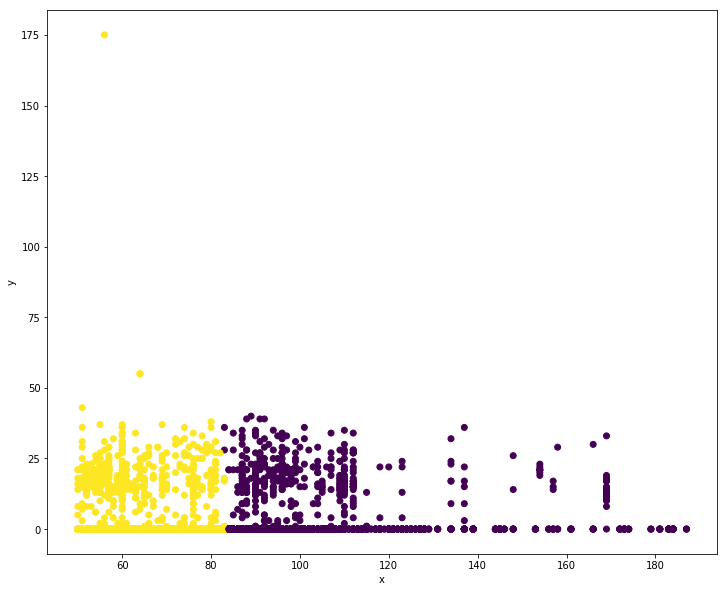

In [136]:
%matplotlib inline
threedee = plt.figure(figsize=(12,10)).gca()
threedee.scatter(pddf_pred.hr_value, pddf_pred.step_value, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
plt.show()

In [137]:
sc.stop()

In [99]:
pddf_pred.index = pddf_pred.index.astype(int)
pddf_pred.sort_index(inplace=True)
pddf_pred.head()

,prediction,hr_value,step_value
id,,,
0,0,84.0,0.0
1,0,84.0,0.0
2,0,84.0,0.0
3,0,84.0,0.0
4,1,79.0,0.0


In [103]:
pddf_pred.join([df['timestamp']])

,prediction,hr_value,step_value,timestamp
id,,,,
0,0,84.0,0.0,1.553677e+09
1,0,84.0,0.0,1.553677e+09
2,0,84.0,0.0,1.553677e+09
3,0,84.0,0.0,1.553677e+09
4,1,79.0,0.0,1.553677e+09
5,1,79.0,0.0,1.553677e+09
6,1,79.0,0.0,1.553677e+09
7,1,79.0,0.0,1.553677e+09
8,1,79.0,0.0,1.553677e+09


In [112]:
df.to_csv('out.csv')

['prediction', 'hr_value', 'step_value', 'user']